In [25]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import seaborn as sns
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb
from xgboost import XGBClassifier
import shap
import time


In [2]:
%matplotlib inline
sns.set(color_codes=True)
pd.set_option('display.max_columns', 100)
# pd.set_option('display.max_columns',None)

In [3]:
# load data
train = pd.read_pickle("train")
history_data = pd.read_pickle("hist_data_df")

#### Load Data

In [4]:
train = pd.merge(train, history_data, on="id")

In [5]:
train.shape

(193002, 54)

In [6]:
pd.DataFrame({"Dataframe columns": train.columns})

,Dataframe columns
0,id
1,cons_12m
2,cons_gas_12m
3,cons_last_month
4,forecast_cons_12m
5,forecast_discount_energy
6,forecast_meter_rent_12m
7,forecast_price_energy_p1
8,forecast_price_energy_p2
9,forecast_price_pow_p1


#### Train Test Split

In [7]:
y = train["churn"]
X = train.drop(labels = ["id","churn"],axis = 1)

In [8]:
# Split training/test datasets
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

In [9]:
# Define the logistic regression model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [10]:
# Train the model: naive logistic regression
log_classifier = LogisticRegression(solver="liblinear",max_iter=1500)
log_classifier.fit(X_train,y_train)

LogisticRegression(max_iter=1500, solver='liblinear')

In [11]:
# Display the confusion matrix
from sklearn.metrics import confusion_matrix
y_pred_lrc = log_classifier.predict(X_test)
cm_lrc = confusion_matrix(y_test, y_pred_lrc)

# Create a DataFrame from the confusion matrix.
cm_lrc_df = pd.DataFrame(cm_lrc, index=["Retained", "Churned"], columns=["Predicted Retained", "Predicted Churned"])
cm_lrc_df

,Predicted Retained,Predicted Churned
Retained,43501,26
Churned,4709,15


In [12]:
# Evaluate the model

print(f"The accuracy of the model is: {accuracy_score(y_test,y_pred_lrc):.4f}")
print(f"The pecision of the model is: {precision_score(y_test,y_pred_lrc):.4f}")
print(f"The recall of the model is: {recall_score(y_test,y_pred_lrc):.4f}")

The accuracy of the model is: 0.9019
The pecision of the model is: 0.3659
The recall of the model is: 0.0032


In [18]:
xgb_classifier = xgb.XGBClassifier(learning_rate=0.1,max_depth=6,n_estimators=500,n_jobs=2, use_label_encoder =False, eval_metric='mlogloss')
model = xgb_classifier.fit(X_train,y_train)

In [19]:
# Display the confusion matrix
from sklearn.metrics import confusion_matrix
y_pred_xgbc = model.predict(X_test)
cm_xgbc = confusion_matrix(y_test, y_pred_xgbc)

# Create a DataFrame from the confusion matrix.
cm_xgbc_df = pd.DataFrame(cm_xgbc, index=["Retained", "Churned"], columns=["Predicted Retained", "Predicted Churned"])
cm_xgbc_df

,Predicted Retained,Predicted Churned
Retained,43519,8
Churned,764,3960


In [20]:
y_pred_xgbc = xgb_classifier.predict(X_test)
print(f"The accuracy of the model is: {accuracy_score(y_test,y_pred_xgbc):.4f}")
print(f"The pecision of the model is: {precision_score(y_test,y_pred_xgbc):.4f}")
print(f"The recall of the model is: {recall_score(y_test,y_pred_xgbc):.4f}")

The accuracy of the model is: 0.9840
The pecision of the model is: 0.9980
The recall of the model is: 0.8383


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

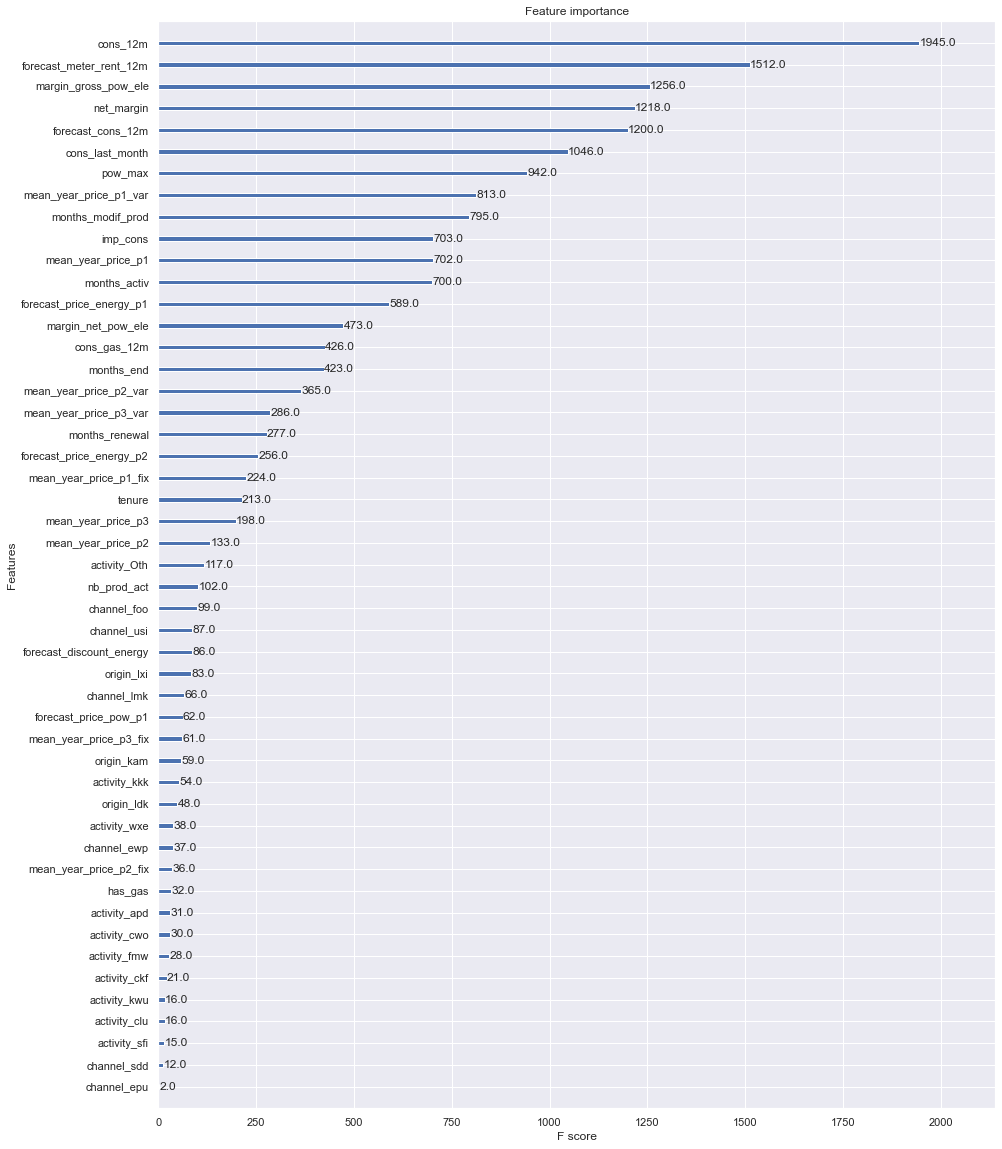

In [27]:
fig, ax = plt.subplots(figsize=(15,20))
xgb.plot_importance(model, ax=ax)